In [2]:
import pandas as pd
import numpy as np
import util
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from matplotlib.lines import Line2D

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import umap
import umap.plot
import seaborn as sns

data = np.load('../Output/CompareFineGrainedModelsSingleVsMultiple/fine_grained_trainedon_Classroom_m1_242.h5_gradcam_and_embeddings.npz')
gradcam1 = data['gradcam']
embeddings1 = data['embeddings']
csv1 = pd.read_csv('../Output/CompareFineGrainedModelsSingleVsMultiple/fine_grained_trainedon_Classroom_m1_242.h5_output.csv')

data = np.load('../Output/CompareFineGrainedModelsSingleVsMultiple/fine_grained_trainedon_ClassroomOffice_m1m2m3_242-fixed.h5_gradcam_and_embeddings.npz')
gradcam2 = data['gradcam']
embeddings2 = data['embeddings']
csv2 = pd.read_csv('../Output/CompareFineGrainedModelsSingleVsMultiple/fine_grained_trainedon_ClassroomOffice_m1m2m3_242-fixed.h5_output.csv')

print('Grad-CAM shape:', gradcam1.shape, gradcam2.shape)
print('Embeddings shape:', embeddings1.shape, embeddings2.shape)
print('CSV shape:', csv1.shape, csv2.shape)

2025-06-02 02:09:22.071810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-02 02:09:22.162520: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-02 02:09:22.180807: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-02 02:09:22.362037: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-02 02:09:23.212696: W tensorflow/compiler/tf2

Grad-CAM shape: (4441, 25, 121) (4441, 25, 121)
Embeddings shape: (4441, 92928) (4441, 92928)
CSV shape: (4441, 6) (4441, 6)


----
# Predictions confidence distributions

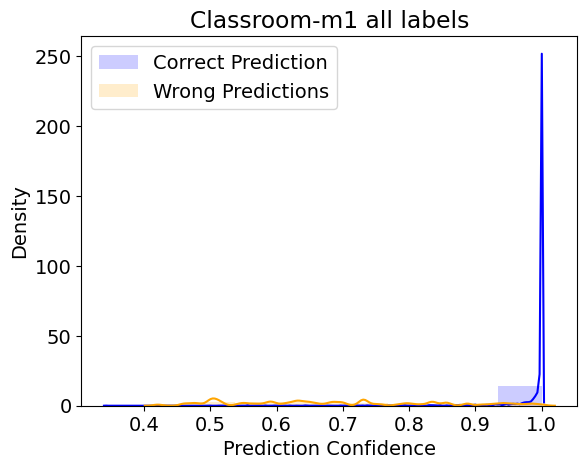

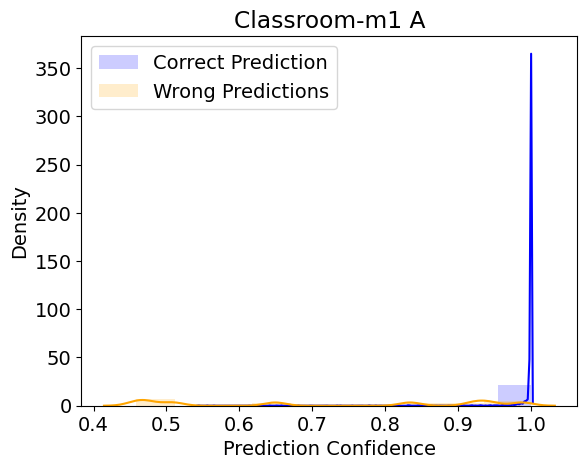

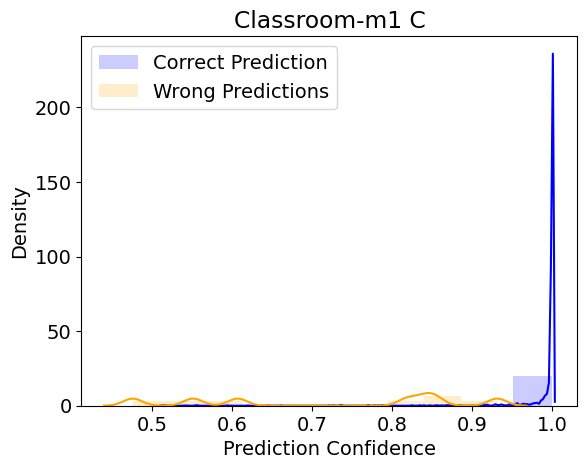

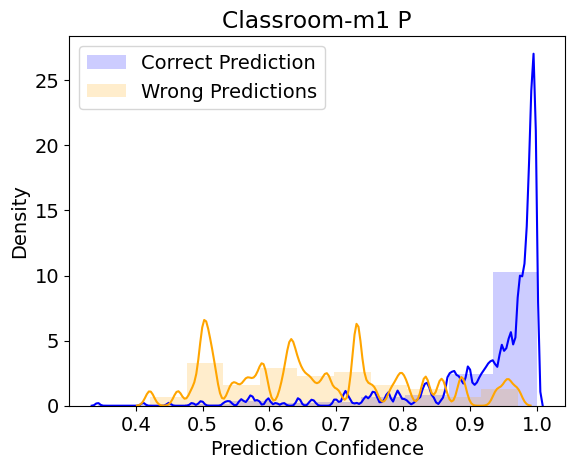

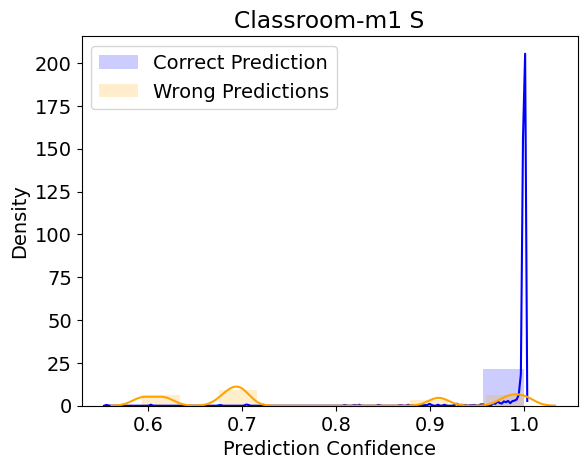

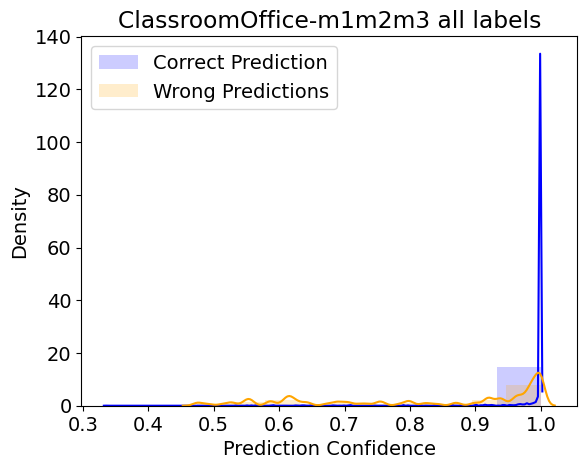

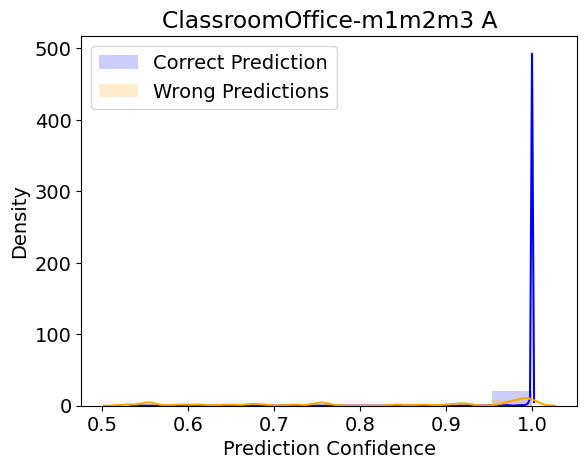

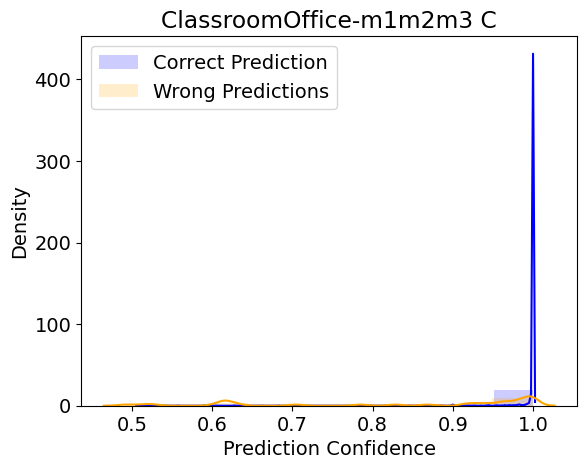

/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


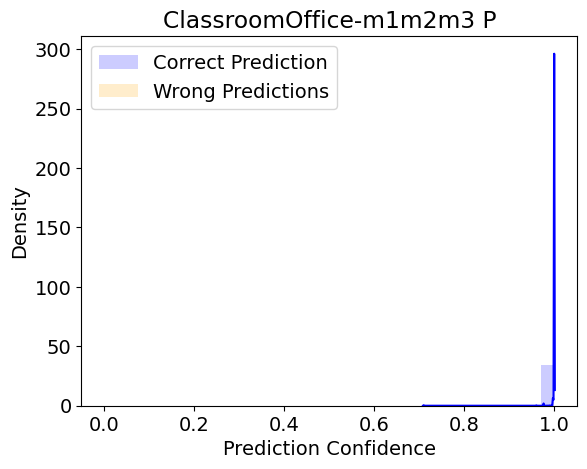

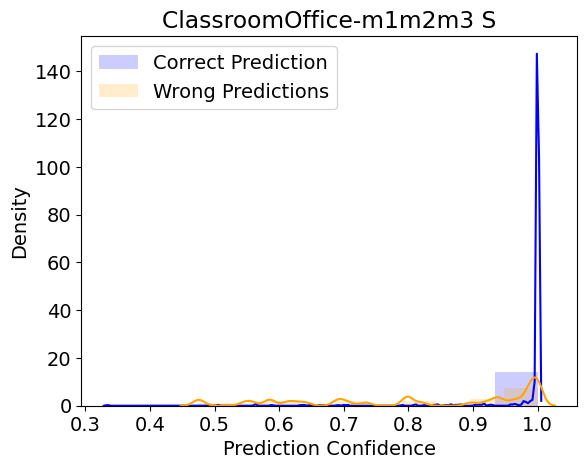

In [168]:
labels = ['A', 'C', 'P', 'S']
csvs = [csv1, csv2]
titles = ['Classroom-m1', 'ClassroomOffice-m1m2m3']
index = 0
for csv in csvs:
  right_predictions = csv.loc[csv['right_prediction']==True, 'predicted_prob'].to_list()
  false_predictions = csv.loc[csv['right_prediction']==False, 'predicted_prob'].to_list()
  util.plot_prediction_confidence_distribution(right_predictions, false_predictions, title=f'{titles[index]} all labels')
  for label in labels:
    right_predictions = csv.loc[(csv['right_prediction']==True) & (csv['label']==label), 'predicted_prob'].to_list()
    false_predictions = csv.loc[(csv['right_prediction']==False) & (csv['label']==label), 'predicted_prob'].to_list()
    util.plot_prediction_confidence_distribution(right_predictions, false_predictions, title=f'{titles[index]} {label}')
  index += 1

In [216]:
csv = csv1
label = 'S'
right_predictions = csv.loc[(csv['right_prediction']==True) & (csv['label']==label) & (csv['source'].str.contains('fine_grained/Classroom/80MHz/3mo/m1/Slots/Test/test_set.csv'))]
false_predictions = csv.loc[(csv['right_prediction']==False) & (csv['label']==label) & (csv['source'].str.contains('fine_grained/Classroom/80MHz/3mo/m1/Slots/Test/test_set.csv'))]
print(f'right={len(right_predictions)}, false={len(false_predictions)}, total={len(right_predictions)+len(false_predictions)}')


right=661, false=8, total=669


In [217]:
csv = csv2
label = 'S'
csv.loc[(csv['right_prediction']==True) & (csv['label']==label) & (csv['source'].str.contains('fine_grained/Classroom/80MHz/3mo/m1/Slots/Test/test_set.csv'))]
print(f'right={len(right_predictions)}, false={len(false_predictions)}, total={len(right_predictions)+len(false_predictions)}')


right=661, false=8, total=669


**Anotações**
- A distribuições da confinça das predições varia bastante na classe P (reading) entre os modelos. Talvez esse gráfico seja útil para mostra para uma pessoa leiga que o modelo 2 tem mais certeza tanto na hora de prever certo e errado para essa classe.

In [ ]:
def plot_prediction_confidence_distribution(numbers1, numbers2, lim=3, bw=0.1, title="test", x="Prediction Confidence", y="Density", output=None):
    # Increase fonts
    plt.rcParams.update({'font.size': 14})
    
    sns.kdeplot(numbers1, fill=False, bw_adjust=bw, color='blue')
    sns.kdeplot(numbers2, fill=False, bw_adjust=bw, color="orange")
    plt.hist(numbers1, histtype='stepfilled', alpha=0.2, density=True, color='blue', label="Correct Prediction")
    plt.hist(numbers2, histtype='stepfilled', alpha=0.2, density=True, color="orange", label="Wrong Predictions")
    plt.title(title)
    # set font of xlabel
    plt.xlabel(x, fontsize=14) 
    plt.xticks(fontsize=14)
    plt.xlabel(x)
    plt.ylabel(y)
    #plt.ylim(0,lim)
    plt.legend(loc = 'upper left')
    if output is not None:
      plt.savefig(output, format = 'png')
  
    plt.show()

/home/diogo/miniconda3/envs/tensorflow/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


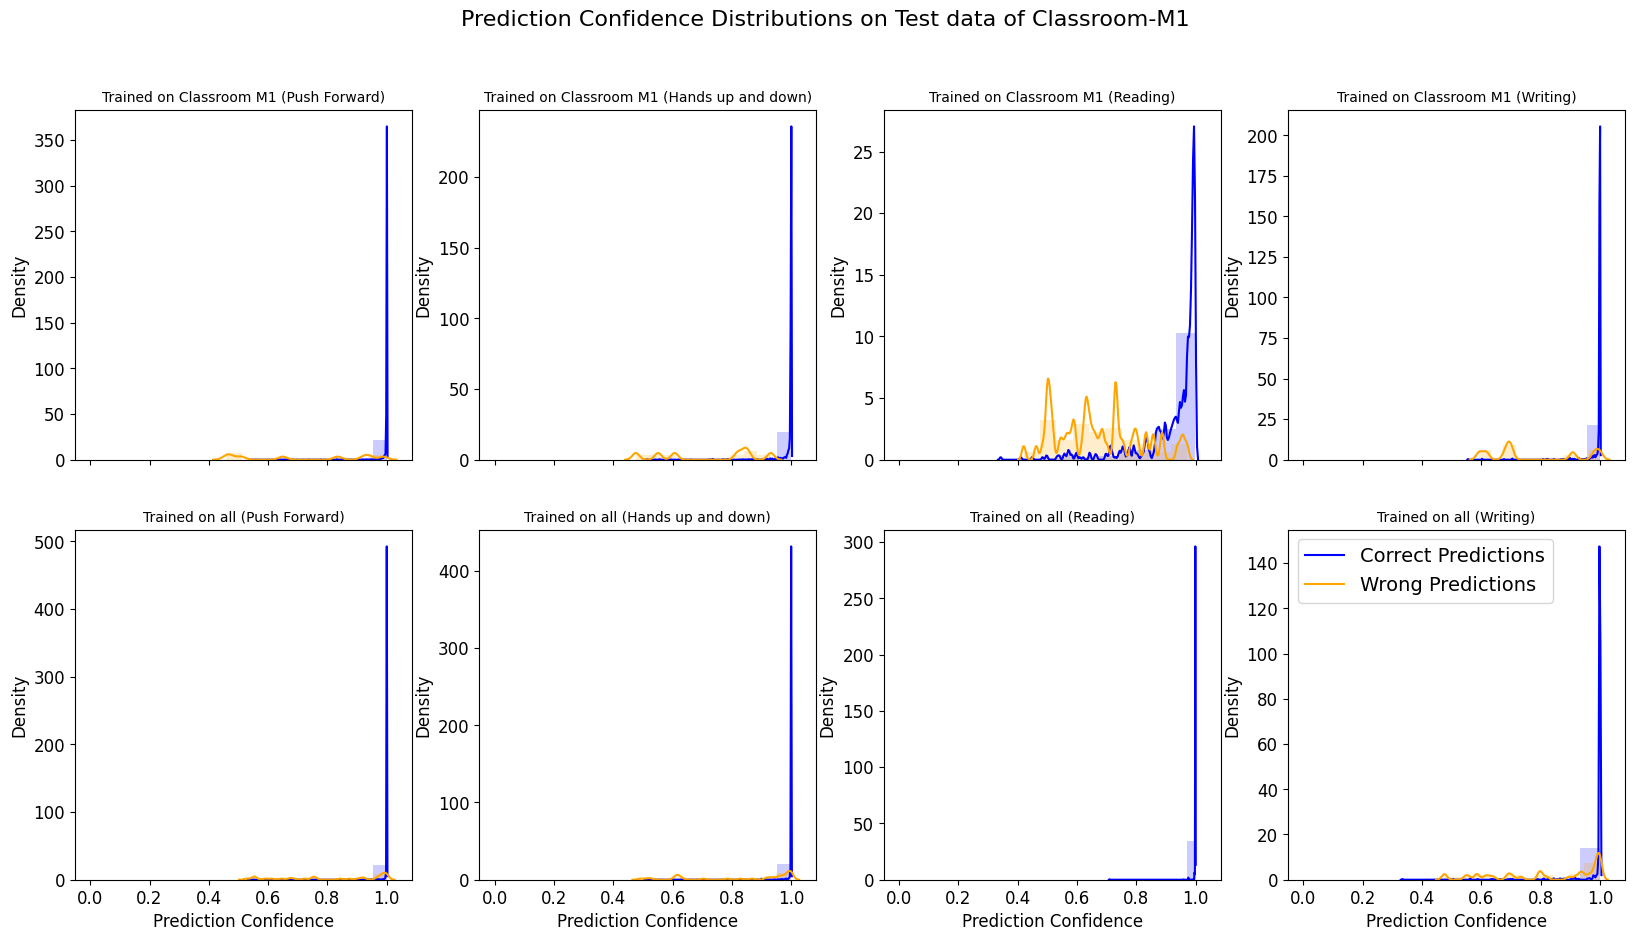

: 

In [ ]:
def plot_confidences():
  csvs = [csv1, csv2]
  labels = ['A', 'C', 'P', 'S']
  labels_english = ['Push Forward', 'Hands up and down', 'Reading', 'Writing']
  titles = ['Trained on Classroom M1', 'Trained on all']
  rows = 2
  cols = 4
  bw = 0.1
  fig, axs = plt.subplots(rows, cols, figsize=(20, 10), sharex=True)
  fig.suptitle('Prediction Confidence Distributions on Test data of Classroom-M1', fontsize=16)

  for row_index in range(rows):
    for col_index in range(cols):
      title = f'{titles[row_index]} ({labels_english[col_index]})'
      label = labels[col_index]
      csv = csvs[row_index]
      right_predictions = csv.loc[(csv['right_prediction']==True) & (csv['label']==label) & (csv['source'].str.contains('fine_grained/Classroom/80MHz/3mo/m1/Slots/Test/test_set.csv')), 'predicted_prob'].to_list()
      false_predictions = csv.loc[(csv['right_prediction']==False) & (csv['label']==label) & (csv['source'].str.contains('fine_grained/Classroom/80MHz/3mo/m1/Slots/Test/test_set.csv')), 'predicted_prob'].to_list()
      sns.kdeplot(right_predictions, fill=False, bw_adjust=bw, color='blue', ax=axs[row_index, col_index], label='Correct Predictions')
      sns.kdeplot(false_predictions, fill=False, bw_adjust=bw, color='orange', ax=axs[row_index, col_index], label='Wrong Predictions')
      axs[row_index, col_index].hist(right_predictions, histtype='stepfilled', alpha=0.2, density=True, color='blue')
      axs[row_index, col_index].hist(false_predictions, histtype='stepfilled', alpha=0.2, density=True, color="orange")
      axs[row_index, col_index].set_title(title, fontsize=10)
      axs[row_index, col_index].set_xlabel('Prediction Confidence', fontsize=12)
      axs[row_index, col_index].set_ylabel('Density', fontsize=12)
      axs[row_index, col_index].tick_params(axis='both', which='major', labelsize=12)
  # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.legend(loc='upper left')
  plt.savefig('SAIDAS/11-prediction_confidence_distributions.png', format='png', bbox_inches='tight', dpi=300)
  plt.show()

plot_confidences()   


----
# GradCam


In [8]:
csv_merged = pd.merge(left=csv1, right=csv2, how='inner', on='filename', suffixes=('_m1', '_m1m2m3'))
csv_merged.loc[(csv_merged['right_prediction_m1']==True) & (csv_merged['right_prediction_m1m2m3']==True), 'both_right_prediction'] = True
csv_merged['both_right_prediction'] = csv_merged['both_right_prediction'].fillna(False)

# Create a sort key for the filenames
csv_merged['sort_key'] = csv_merged['filename'].str.split('_', expand=True)[0] + '_' + csv_merged['filename'].str.split('_', expand=True)[1] + '_' + csv_merged['filename'].str.split('_', expand=True)[2].str.split('.', expand=True)[0].str.zfill(5)


# Create a new index based on the sorted filenames
csv_merged.sort_values(by='sort_key', inplace=True)
csv_merged = csv_merged.reset_index()
csv_merged.rename(columns={'index': 'gradcam_index'}, inplace=True)


# Constants
activities = {
  'A': 'Push forward',
  'C': 'Hands up and down',
  'P': 'Reading',
  'S': 'Writing'
}

def compute_iou(cam1, cam2, threshold=0.2):
  cam1_bin = cam1 > threshold
  cam2_bin = cam2 > threshold
  intersection = np.logical_and(cam1_bin, cam2_bin).sum(axis=(1,2))
  union = np.logical_or(cam1_bin, cam2_bin).sum(axis=(1,2))
  iou = np.divide(intersection, union, out=np.zeros_like(intersection, dtype=float), where=union != 0)
  return iou

/tmp/ipykernel_3273123/4001204729.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  csv_merged['both_right_prediction'] = csv_merged['both_right_prediction'].fillna(False)


In [163]:
from sklearn.metrics.pairwise import cosine_similarity

def plot_gradcam(gradcam1, gradcam2, csv_merged, label):
  subset = csv_merged.loc[(csv_merged['both_right_prediction']==True) & (csv_merged['label_m1']==label)]
  rows = len(subset) // 3
  # rows = 10
  cols = 6

  # Compute similarties
  # Cosine similarity
  gradcam1flatten = gradcam1[subset['gradcam_index']].reshape(len(subset), -1)
  gradcam2flatten = gradcam2[subset['gradcam_index']].reshape(len(subset), -1)
  cos_sim = cosine_similarity(gradcam1flatten, gradcam2flatten)[0, :]
  cos_sim_threshold = np.percentile(cos_sim, 95)
  com_sim_top_indexes = np.where(cos_sim > cos_sim_threshold)[0]
  # IoU @ 0.2
  iou = compute_iou(gradcam1[subset['gradcam_index']], gradcam2[subset['gradcam_index']], threshold=0.2)
  iou_threshold = np.percentile(iou, 96)
  iou_top_indexes = np.where(iou >= iou_threshold)[0]

  fig, axs = plt.subplots(rows, cols, figsize=(15, rows), dpi=110)

  for row in tqdm(range(rows)):
    for i in range(3):  # 3 pares de imagens por linha
      col_base = 2 * i
      index = row + i * rows
      filename = subset.iloc[index]['filename']
      filename = f'{filename[0]}/{filename[14:-4]}'
      gradcam_index = subset.iloc[index]['gradcam_index']
      predicted_prob_m1 = subset.iloc[index]['predicted_prob_m1'] * 100
      predicted_prob_m1m2m3 = subset.iloc[index]['predicted_prob_m1m2m3'] * 100

      # GradCAM 1
      resized = cv2.resize(gradcam1[gradcam_index], (242, 50))
      axs[row, col_base].imshow(resized, cmap='jet')
      axs[row, col_base].set_xlabel(f'{predicted_prob_m1:.2f}%', fontsize=9)
      axs[row, col_base].set_xticks([])
      axs[row, col_base].set_yticks([])
      axs[row, col_base].set_ylabel(filename, fontsize=9, fontweight='bold')

      # GradCAM 2
      resized = cv2.resize(gradcam2[gradcam_index], (242, 50))
      axs[row, col_base + 1].imshow(resized, cmap='jet')

      label2 = f'{predicted_prob_m1m2m3:.2f}%'
      if index in com_sim_top_indexes:
        label2 = f'{label2} (Top95%CosSim)'
      if index in iou_top_indexes:
        label2 = f'{label2} (Top96%IoU)'

        
      axs[row, col_base + 1].set_xlabel(label2, fontsize=7)
      axs[row, col_base + 1].set_xticks([])
      axs[row, col_base + 1].set_yticks([])

      if row == 0:
        axs[row, col_base].set_title(f'Classroom-m1', fontsize=10, fontweight='bold')
        axs[row, col_base + 1].set_title(f'ClassroomOffice-m1m2m3', fontsize=10, fontweight='bold')

  line1 = Line2D([0.335, 0.335], [0.0, 1.0], color='black', linewidth=2, linestyle='-')
  line2 = Line2D([0.665, 0.665], [0.0, 1.0], color='black', linewidth=2, linestyle='-')
  fig.add_artist(line1)
  fig.add_artist(line2)

  # Tamanho total da figura em polegadas × DPI = altura em pixels
  fig_height_px = fig.get_size_inches()[1] * fig.dpi
  pixels_reserved = 10  # por exemplo

  # Converter pixels para fração da altura
  top_fraction = 1 - pixels_reserved / fig_height_px

  # Aplicar no tight_layout
  plt.tight_layout(rect=[0, 0, 1, top_fraction])
  plt.suptitle(f'Grad-CAM Heatmaps for Classroom-m1 and ClassroomOffice-m1m2m3 Models Label={label} ({activities[label]})', fontsize=10, fontweight='bold', y=top_fraction)

  save_path = f'../Output/CompareFineGrainedModelsSingleVsMultiple/gradcam_heatmaps_{label}.png'
  plt.savefig(save_path, bbox_inches='tight', dpi=110)
  plt.close()




In [156]:
plot_gradcam(gradcam1, gradcam2, csv_merged, label='P')

100%|██████████| 204/204 [00:00<00:00, 365.15it/s]


In [164]:
for label in activities.keys():
  print(f'Plotting Grad-CAM for label: {label}')
  plot_gradcam(gradcam1, gradcam2, csv_merged, label=label)

Plotting Grad-CAM for label: A


100%|██████████| 537/537 [00:01<00:00, 364.18it/s]


Plotting Grad-CAM for label: C


100%|██████████| 472/472 [00:01<00:00, 358.17it/s]


Plotting Grad-CAM for label: P


100%|██████████| 204/204 [00:00<00:00, 353.29it/s]


Plotting Grad-CAM for label: S


100%|██████████| 208/208 [00:00<00:00, 339.26it/s]


----
Agregando Grad-CAMs 

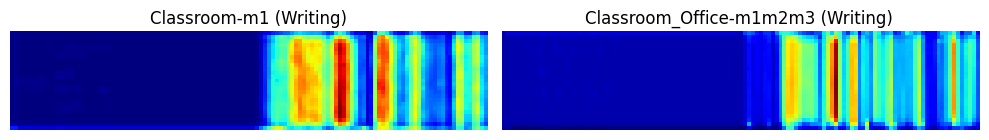

In [33]:
label = 'S'

subset = csv_merged.loc[(csv_merged['both_right_prediction']==True) & (csv_merged['label_m1']==label)]
label_gradcam1 = gradcam1[subset['gradcam_index']]
label_gradcam2 = gradcam2[subset['gradcam_index']]

label_gradcam1_mean = np.mean(label_gradcam1, axis=0)
label_gradcam2_mean = np.mean(label_gradcam2, axis=0)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(label_gradcam1_mean, cmap='jet')
plt.title(f'Classroom-m1 ({activities[label]})')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(label_gradcam2_mean, cmap='jet')
plt.title(f'Classroom_Office-m1m2m3 ({activities[label]}) ')
plt.axis('off')
plt.tight_layout()





---- 
# t-SNE and UMAP of GradCams


In [4]:
# Constants
activities = {
  'A': 'Push forward',
  'C': 'Hands up and down',
  'P': 'Reading',
  'S': 'Writing'
}

# Correct predictions
right1 = csv1.loc[csv1['right_prediction'] == True]
right2 = csv2.loc[csv2['right_prediction'] == True]

# Add GradCam indexes
right1.reset_index(inplace=True)
right1.rename(columns={'index': 'gradcam_index'}, inplace=True)
right2.reset_index(inplace=True)
right2.rename(columns={'index': 'gradcam_index'}, inplace=True)

/tmp/ipykernel_3273123/440440174.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right1.rename(columns={'index': 'gradcam_index'}, inplace=True)
/tmp/ipykernel_3273123/440440174.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  right2.rename(columns={'index': 'gradcam_index'}, inplace=True)


In [ ]:
def plot_tsne(subset, gradcam, title='', output_file=None, perplexity=30):
  X = gradcam[subset['gradcam_index'], :].reshape(len(subset), -1)

  labels = subset['label'].tolist()
  label_encoder = LabelEncoder()
  numeric_labels = label_encoder.fit_transform(labels)
  class_names = label_encoder.classes_
  class_names = np.array([activities[classname] for classname in class_names ])

  colormap = 'tab10'
  cmap = plt.get_cmap(colormap, len(class_names))

  tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
  X_embedded = tsne.fit_transform(X)
  x, y = X_embedded[:, 0], X_embedded[:, 1]

  fig, ax = plt.subplots(1, 2, figsize=(14, 6))
  ax[0].scatter(x, y, c=numeric_labels, cmap=cmap, s=5)
  ax[0].set_title(title)
  ax[0].set_xlabel('t-SNE Component 1')
  ax[0].set_ylabel('t-SNE Component 2')
  ax[0].grid(True)

  # Polar
  r = np.sqrt(x**2 + y**2)
  theta = np.arctan2(y, x)
  ax[1].scatter(theta, r, c=numeric_labels, cmap=colormap, s=5)
  ax[1].set_title(f'{title} (polar)')
  ax[1].set_xlabel('radius')
  ax[1].set_ylabel('theta')

  plt.tight_layout()

  legend_handles = []
  for i, class_name in enumerate(class_names):
      # Use the same cmap to get the color for each class
      color = cmap(i)
      legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', label=class_name,
                                      markersize=10, markerfacecolor=color))

  plt.legend(handles=legend_handles, loc='upper right', bbox_to_anchor=(1.15, 1), fontsize=8)


  if output_file is not None:
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
  plt.show()


def plot_umap(subset, gradcam, title='', output_file=None, n_neighbors=15, min_dist=0.1, low_memory=False):
  X = gradcam[subset['gradcam_index'], :].reshape(len(subset), -1)

  labels = subset['label'].tolist()

  label_encoder = LabelEncoder()
  numeric_labels = label_encoder.fit_transform(labels)
  class_names = label_encoder.classes_
  class_names = np.array([activities[classname] for classname in class_names ])

  mapper = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, low_memory=low_memory).fit(X)
  umap.plot.points(mapper, labels=class_names[numeric_labels], cmap='tab10')
  plt.title(title)
  if output_file is not None:
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
  



In [ ]:
plot_tsne(right1, gradcam1, title='t-SNE for Classroom-m1 Correct GradCams', perplexity=5, output_file='../Output/CompareFineGrainedModelsSingleVsMultiple/tsne_Classroom_m1_correct_gradcam.png')
plot_tsne(right2, gradcam2, title='t-SNE for ClassroomOffice-m1m2m3 Correct GradCams', perplexity=5, output_file='../Output/CompareFineGrainedModelsSingleVsMultiple/tsne_ClassroomOffice_m1m2m3_correct_gradcam.png')
plot_umap(right1, gradcam1, title='UMAP for Classroom-m1 Correct GradCams', n_neighbors=10, min_dist=0.7, output_file='../Output/CompareFineGrainedModelsSingleVsMultiple/umap_Classroom_m1_correct_gradcam.png')
plot_umap(right2, gradcam2, title='UMAP for ClassroomOffice-m1m2m3 Correct GradCams', n_neighbors=10, min_dist=0.7, output_file='../Output/CompareFineGrainedModelsSingleVsMultiple/umap_ClassroomOffice_m1m2m3_correct_gradcam.png')

----
# t-SNE and UMAP of Embeddings


In [ ]:
plot_tsne(right1, embeddings1, title='t-SNE for Classroom-m1 Correct Embeddings', perplexity=5, output_file='../Output/CompareFineGrainedModelsSingleVsMultiple/tsne_Classroom_m1_correct_embeddings.png')
plot_tsne(right2, embeddings2, title='t-SNE for ClassroomOffice-m1m2m3 Correct Embeddings', perplexity=5, output_file='../Output/CompareFineGrainedModelsSingleVsMultiple/tsne_ClassroomOffice_m1m2m3_correct_embeddings.png')

In [ ]:
plot_umap(right1, embeddings1, title='UMAP for Classroom-m1 Correct Embeddings', n_neighbors=10, min_dist=0.7, output_file='../Output/CompareFineGrainedModelsSingleVsMultiple/umap_Classroom_m1_correct_embeddings.png', low_memory=True)

In [ ]:
plot_umap(right2, embeddings2, title='UMAP for ClassroomOffice-m1m2m3 Correct Embeddings', n_neighbors=10, min_dist=0.7, output_file='../Output/CompareFineGrainedModelsSingleVsMultiple/umap_ClassroomOffice_m1m2m3_correct_embeddings.png', low_memory=True)